In [29]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
from torch import nn
from scipy.spatial import KDTree
from model_interpretation import mnist_models
import data_util

cn = plt.matplotlib.colors.CenteredNorm()

root = 'K:/datasets/classification'
n = 5000
random.seed(42)

ds_train, ds_valid = data_util.get_mnist(root, n)

## Interpretation

In [30]:
def prototypes(model, ds):
    '''Find samples at the center of each class (warning, average might not be at the peak of the distribution)'''

    data = torch.zeros((len(ds), 64))
    labels = torch.zeros(len(ds), dtype=torch.long)
    for idx, (img, label) in enumerate(ds):
        res = model.pool(model.conv(img[None,None])).squeeze()
        data[idx] = res
        labels[idx] = label
        
    tree = KDTree(data)
    imgs = []
    for idx in range(10):
        mean = data[labels==idx].mean(dim=0)
        d, sample_idx = tree.query(mean)
        imgs.append(ds[sample_idx][0][None])

    return imgs

def get_map(model, img):
    '''Get activation map.'''

    ret = model.forward_train(img[None,None])
    map = ret['maps'][0]

    return map

def maximum_activating_patches(model, ds, ps, n=10, threshold=1.):
    '''Get patches that maximally activates each feature channel of the model.
    `ps` sets the patch size. This should be the kernel size used in the layer.
    If the maximum activation of a channel is less than `threshold`, this channel
    is ignored. `n` patches are returned for each non-ignored feature. '''

    ps2 = ps//2

    model.requires_grad_(False)
    model.eval()
    img = ds[0][0]
    img_nr, img_nc = img.shape
    map = get_map(model, img)
    num_features = map.shape[0]

    # Get maximum activations
    features = torch.zeros((len(ds_train), num_features))
    indices = torch.zeros((len(ds_train), num_features), dtype=int)
    for idx, (img, label) in enumerate(ds_train):
        map = get_map(model, img)
        # Maximum activation on flattened tensor
        pool, ind = map.reshape(64,-1).max(dim=1)
        features[idx] = pool
        indices[idx] = ind

    
    # Get n patches that maximally activate each feature
    patches = {}
    for feature_idx in range(num_features):
        features_c = features[:,feature_idx]
        inds_ord = features_c.argsort(descending=True)
        largest_act = features_c[inds_ord[0]]
        if largest_act>threshold:
            patches[feature_idx] = []
            for idx in range(n):
                img_idx = inds_ord[idx]             # img that activated the feature
                act = features_c[img_idx]           # Value of activation
                pos = indices[img_idx,feature_idx]  # Position of activation
                pos_r = pos//img_nc
                pos_c = pos - pos_r*img_nc

                img = ds_train[img_idx][0]
                img_pad = nn.functional.pad(img, (ps2,ps2,ps2,ps2), value=img.min())    # pad to avoid cropping outside image
                patch = img_pad[pos_r:pos_r+2*ps2+1, pos_c:pos_c+2*ps2+1]
                patches[feature_idx].append((patch,act))

    return patches

def plot_patches(patches):

    for feature_idx, values in patches.items():
        plt.figure(figsize=(20,5))
        for idx, (patches_f, act) in enumerate(values):
            plt.subplot(1, 10, idx+1)
            plt.imshow(patches_f, 'gray')

def interpret(img, model, target, n=5):

    # Classification layer
    w = model.fc.weight
    # Activation maps
    acts = model.conv(img[None])
    # Pooled features
    acts_pool = model.pool(acts).squeeze()
    # Contribution of each pooled feature to the scores of a class
    cont = acts_pool*w[target]
    cont = 100*cont/cont[cont>0].sum()
    acts = acts.squeeze()

    cont_inds = torch.argsort(cont, descending=True)
    cont_s = cont[cont_inds]

    maps = []
    for idx in range(n):
        feature_idx = cont_inds[idx]
        att = nn.functional.relu(acts[feature_idx])
        maps.append((att, feature_idx, cont_s[idx]))

    return maps

def plot_maps(img, maps):
    
    n = len(maps)
    plt.figure(figsize=(10, 3))
    for idx, (map, feature_idx, cont) in enumerate(maps):
        plt.subplot(1, n, idx+1)
        plt.imshow(img[0], 'gray')
        plt.imshow(map, 'inferno', alpha=0.5)
        plt.colorbar()
        plt.title(f'Feature {feature_idx} weight: {cont:.1f}%')
    plt.tight_layout()

def interpret_pairwise(samples, model, n=2):

    w = model.fc.weight
    maps = {}
    for i in range(10):
        maps[i] = {}
        for j in range(10):
            if j!=i:
                maps[i][j] = []

    for c_ref in range(10):
        x = samples[c_ref]
        acts = model.conv(x[None])
        acts_pool = model.pool(acts).squeeze()
        acts = acts.squeeze()
        cont_ref = acts_pool*w[c_ref]

        for c_other in range(10):
            if c_other!=c_ref:
                cont_other = acts_pool*w[c_other]
                cont_diff = (cont_ref - cont_other)
                cont_diff = 100*cont_diff/cont_diff[cont_diff>0].sum()
                cont_inds = torch.argsort(cont_diff, descending=True)
                cont_s = cont_diff[cont_inds]

                for idx in range(n):
                    feature_idx = cont_inds[idx]
                    att = nn.functional.relu(acts[feature_idx])
                    maps[c_ref][c_other].append((att, feature_idx, cont_s[idx]))

    return maps

def plot_pairwise_maps(samples, maps):
       
    for c_ref in range(len(samples)):
        x = samples[c_ref]
        maps_c_ref = maps[c_ref]
        plt.figure(figsize=(7, 25))
        k = 0
        for c_other, maps_other in maps_c_ref.items():
            n = len(maps_other)
            for map, feature_idx, cont in maps_other:
                plt.subplot(9, n, k+1)
                plt.imshow(x[0], 'gray')
                plt.imshow(map, 'inferno', alpha=0.5)
                plt.colorbar()
                plt.title(f'{c_ref}-{c_other}: {cont:.2f}')
                k += 1
    plt.tight_layout()


tensor([10, 11, 17, 22, 38, 52, 59, 61])


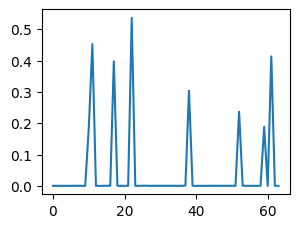

In [31]:
model = mnist_models.CNN()
model.requires_grad_(False)
model.load_state_dict(torch.load('data/weights/cnn_sparse2.pt'))

max_weights = model.conv.weight.abs().amax(dim=(1,2,3))
print(torch.nonzero(max_weights>0.05).T[0])
plt.plot(max_weights)

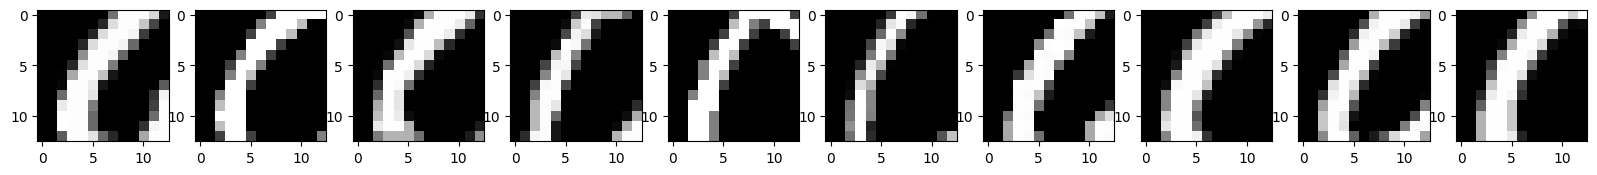

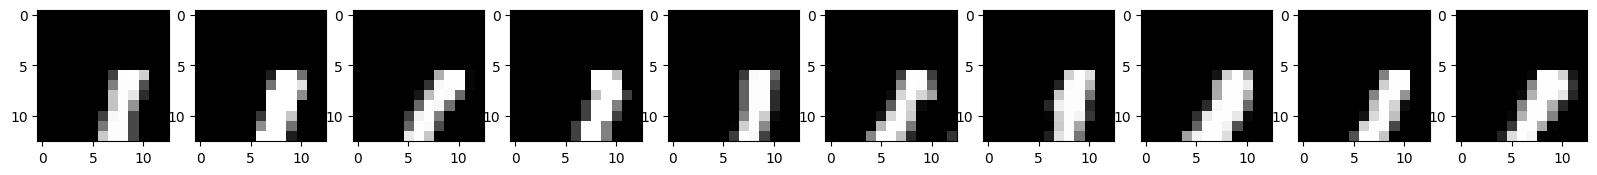

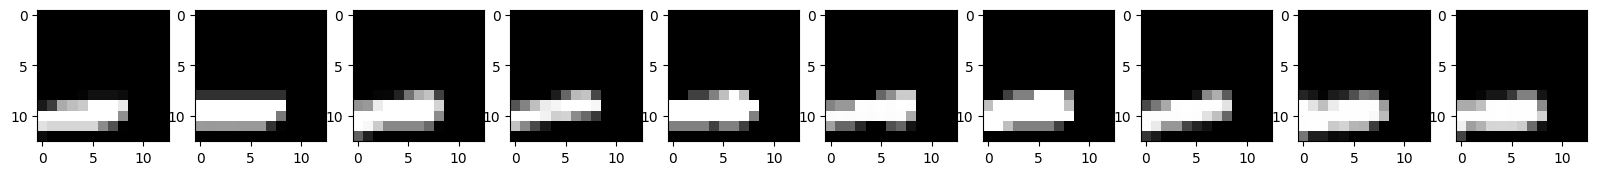

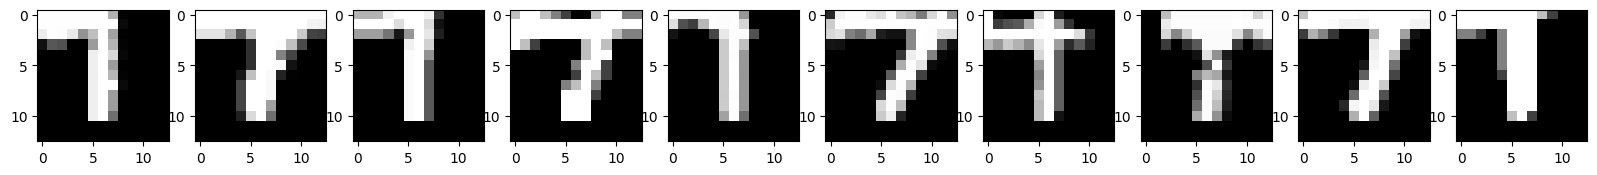

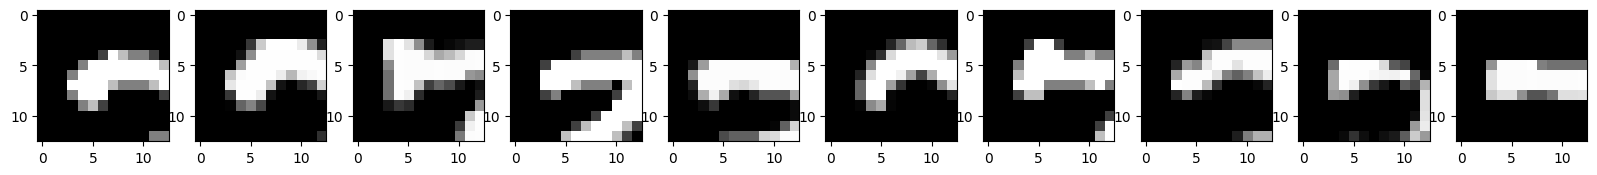

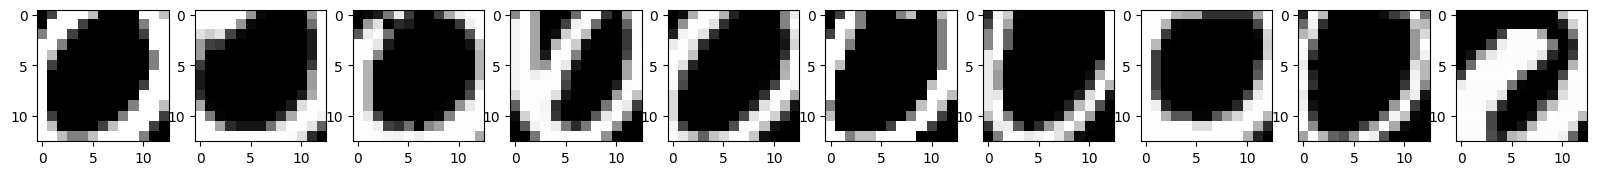

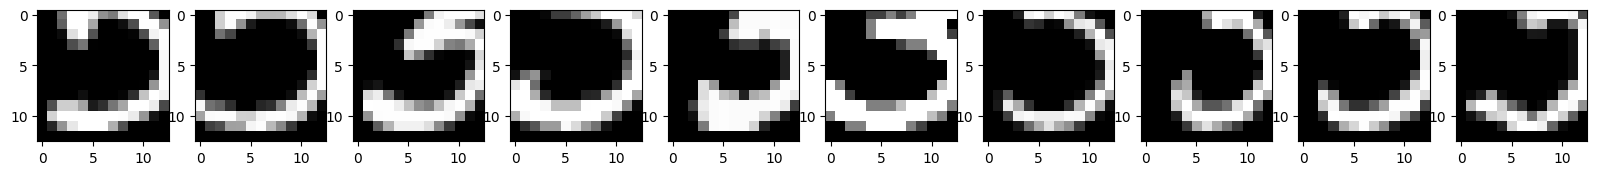

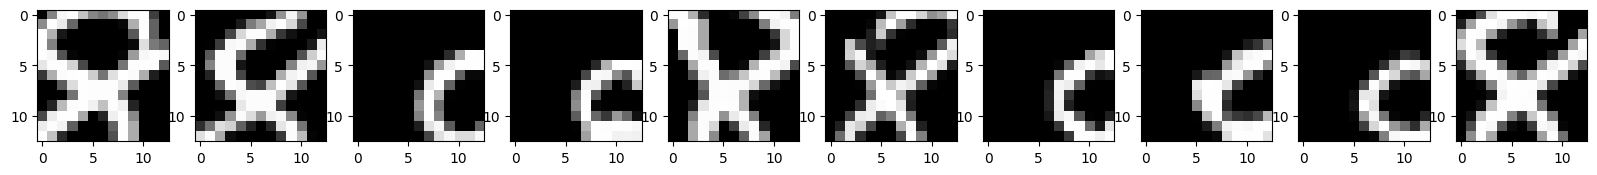

In [32]:
ps = 13
patches = maximum_activating_patches(model, ds_train, ps)
plot_patches(patches)

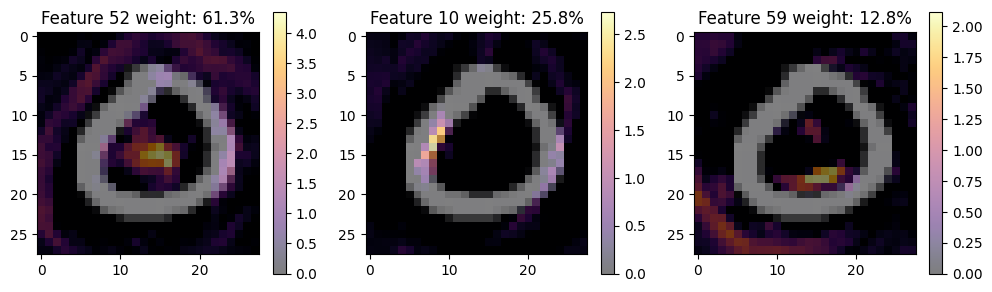

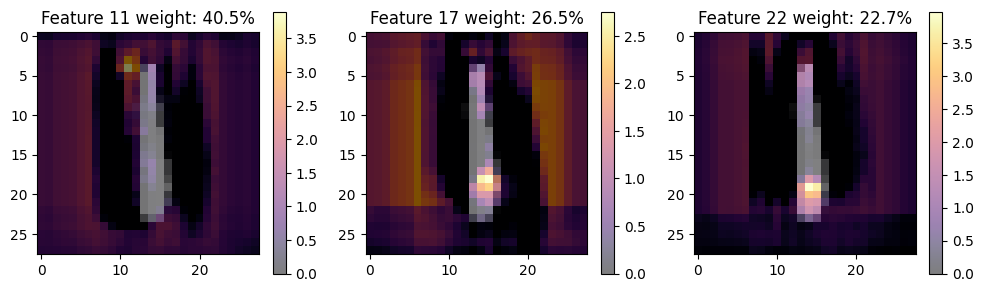

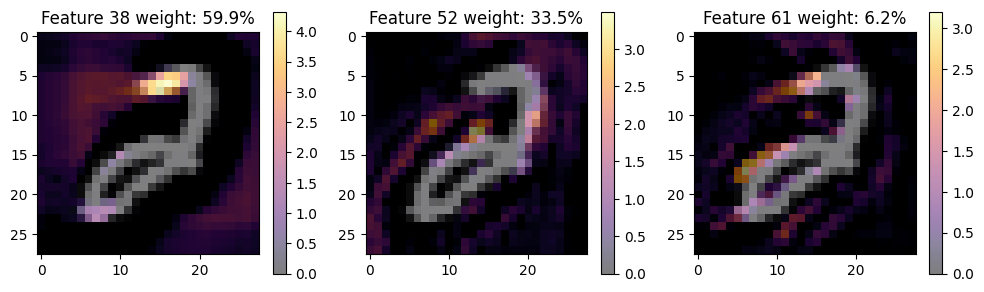

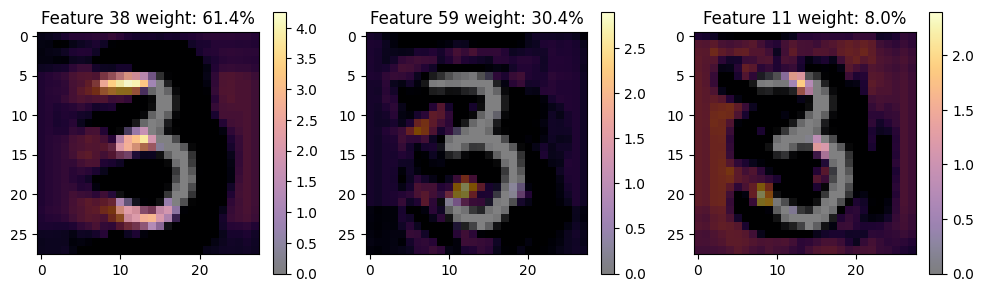

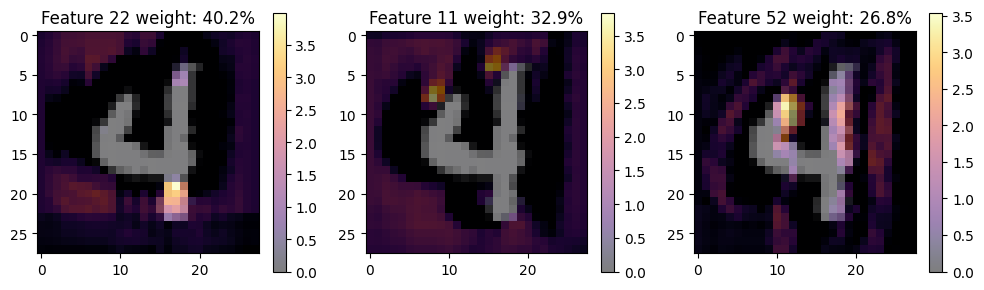

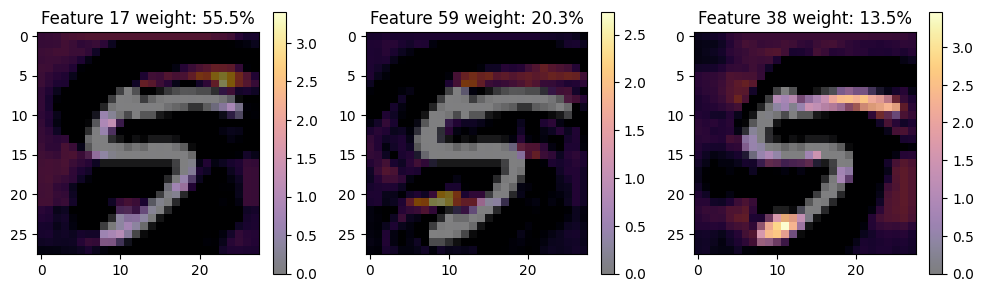

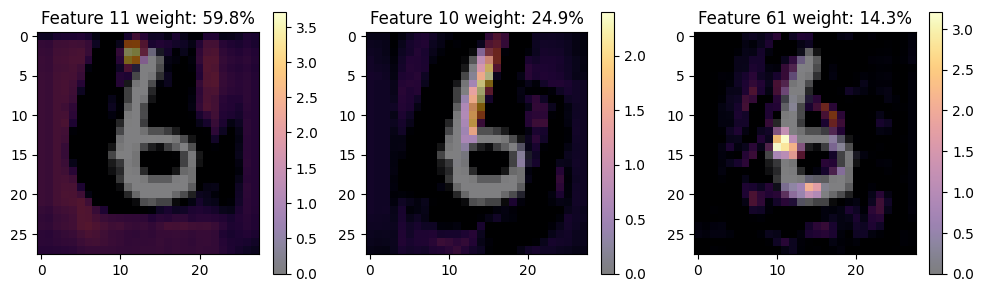

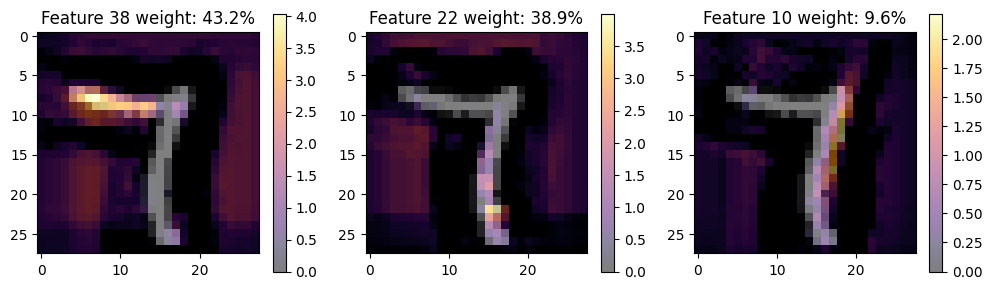

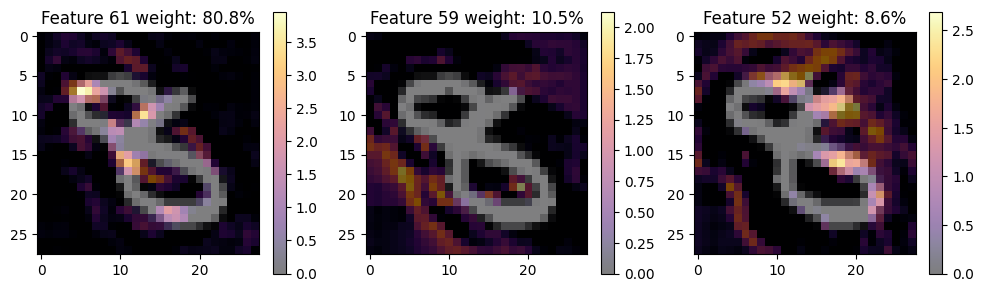

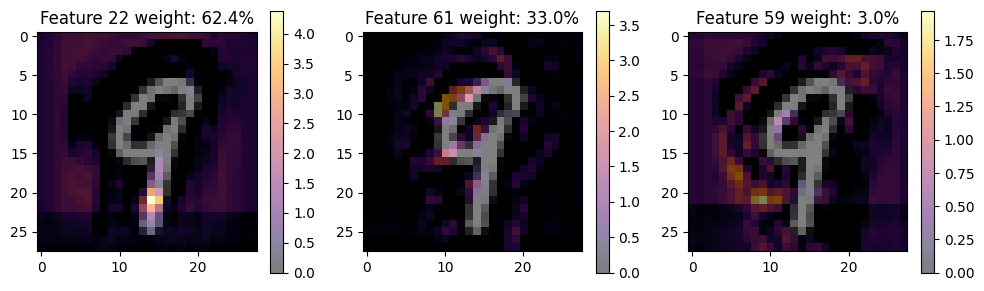

In [33]:
samples = prototypes(model, ds_train)
for c in range(10):
    x = samples[c]
    maps = interpret(x, model, c, n=3)
    plot_maps(x, maps)

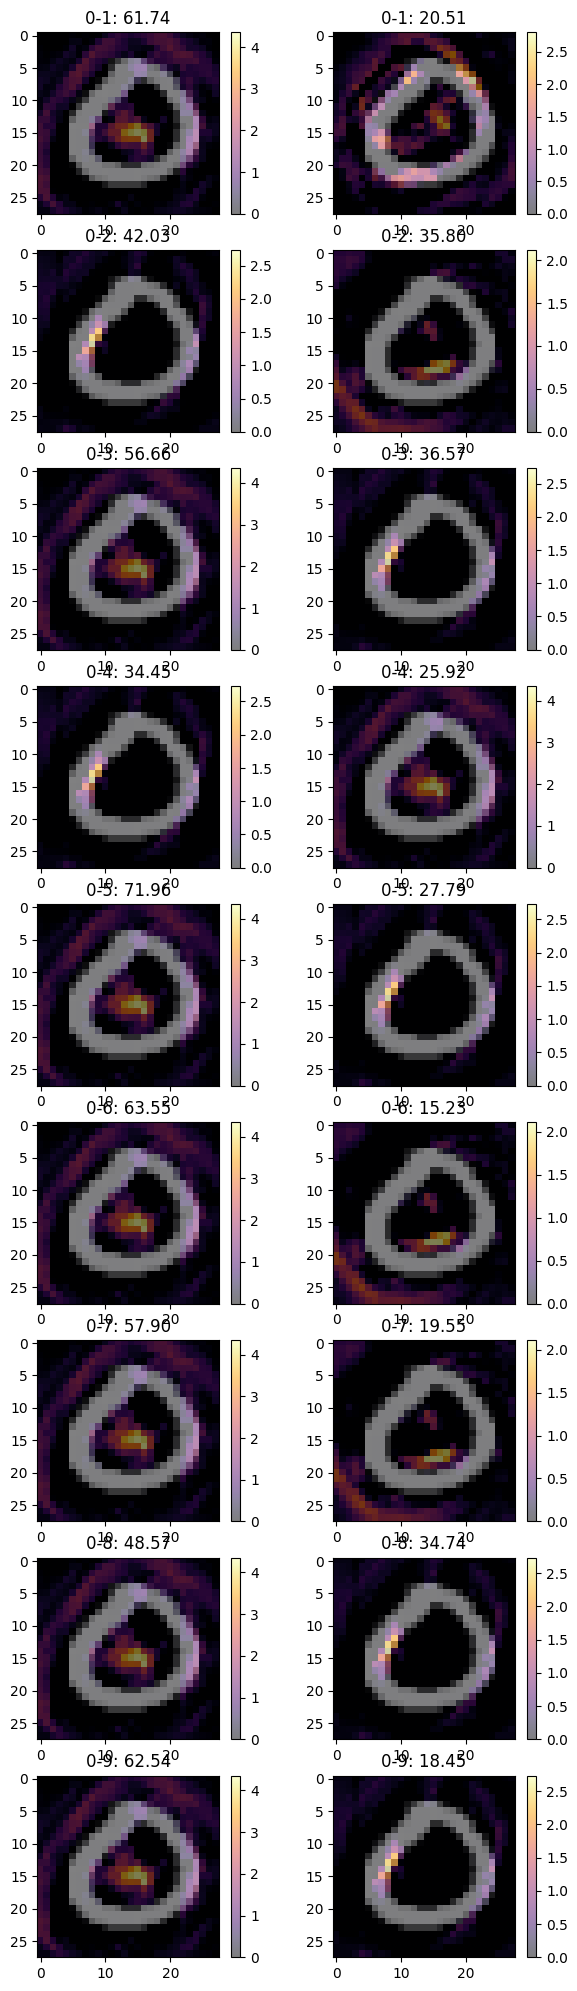

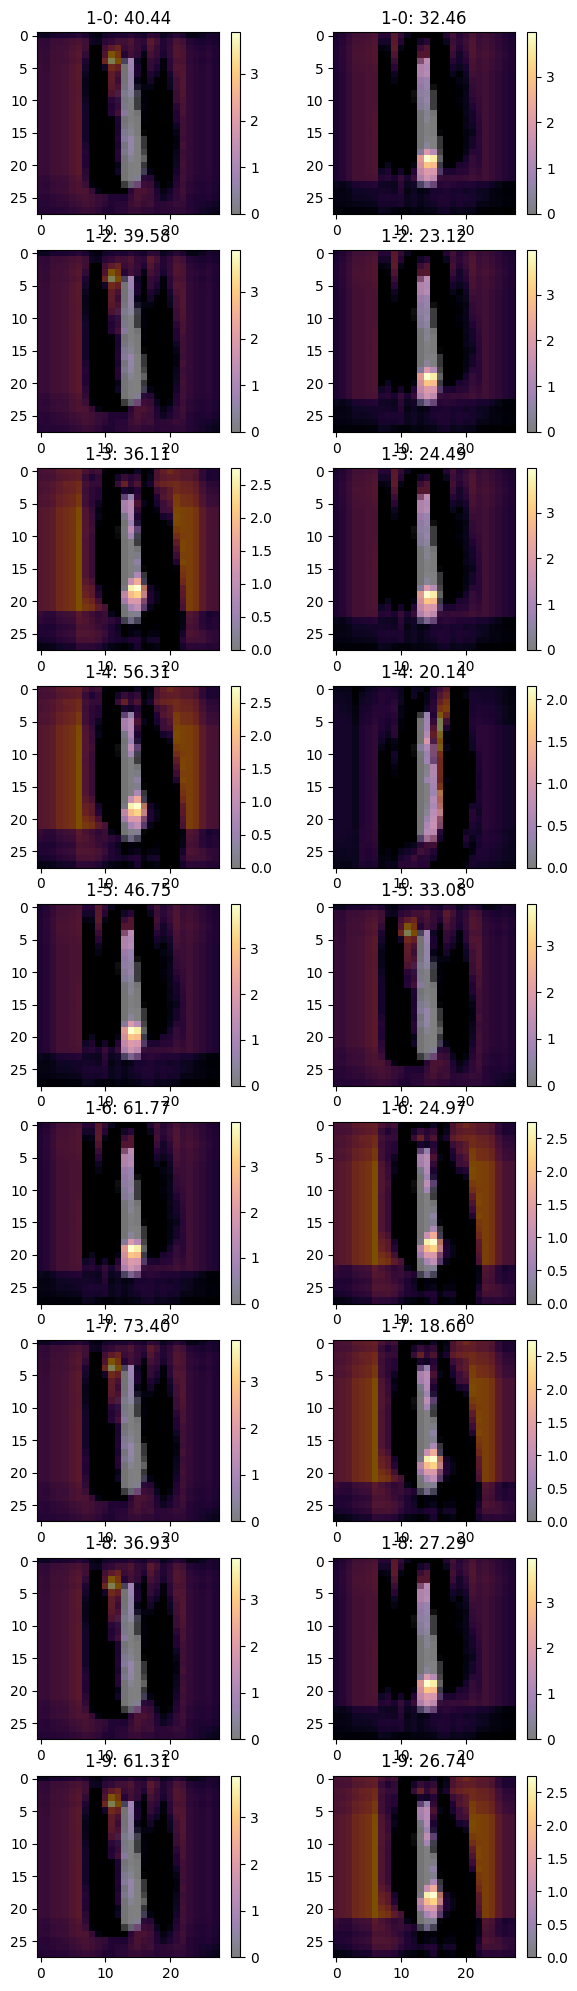

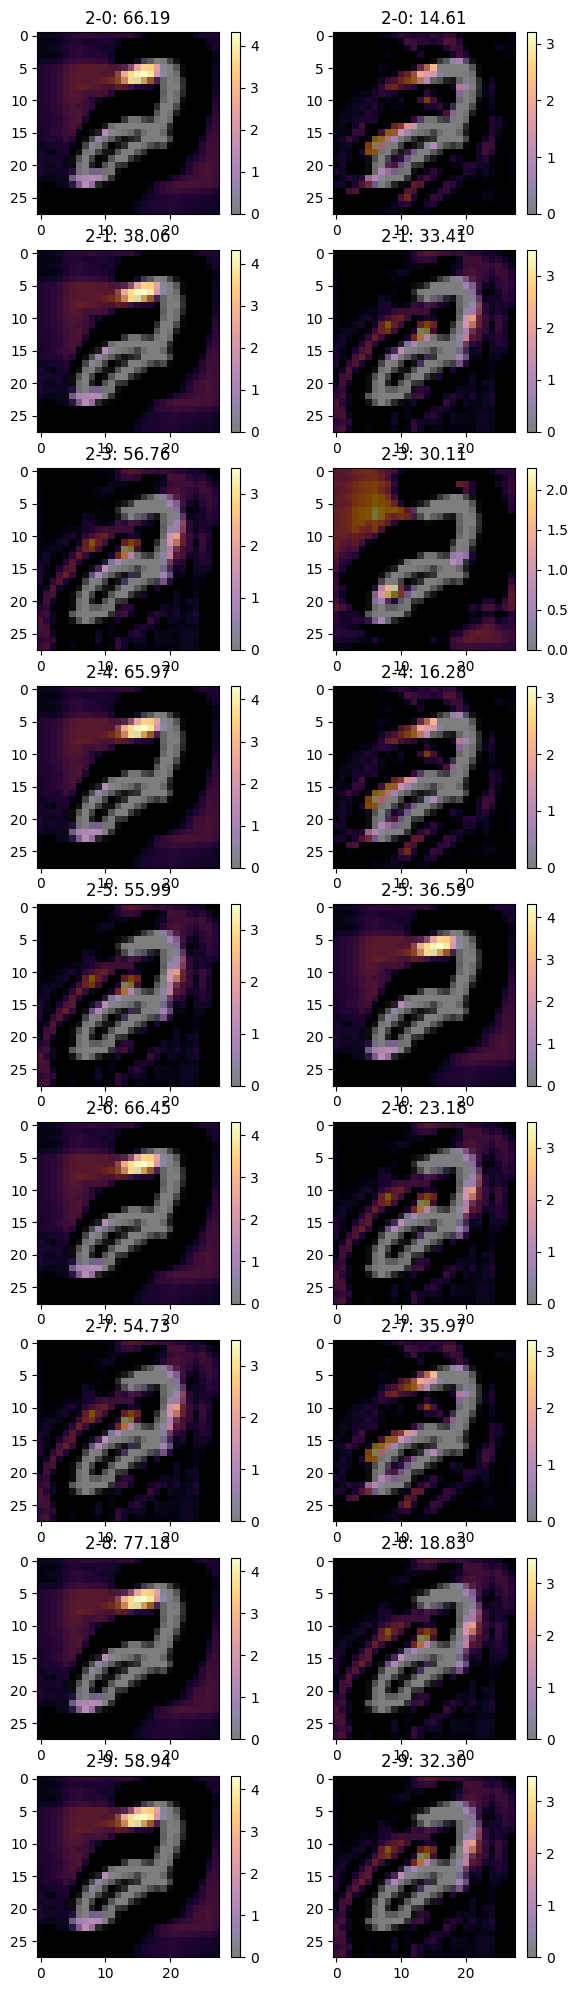

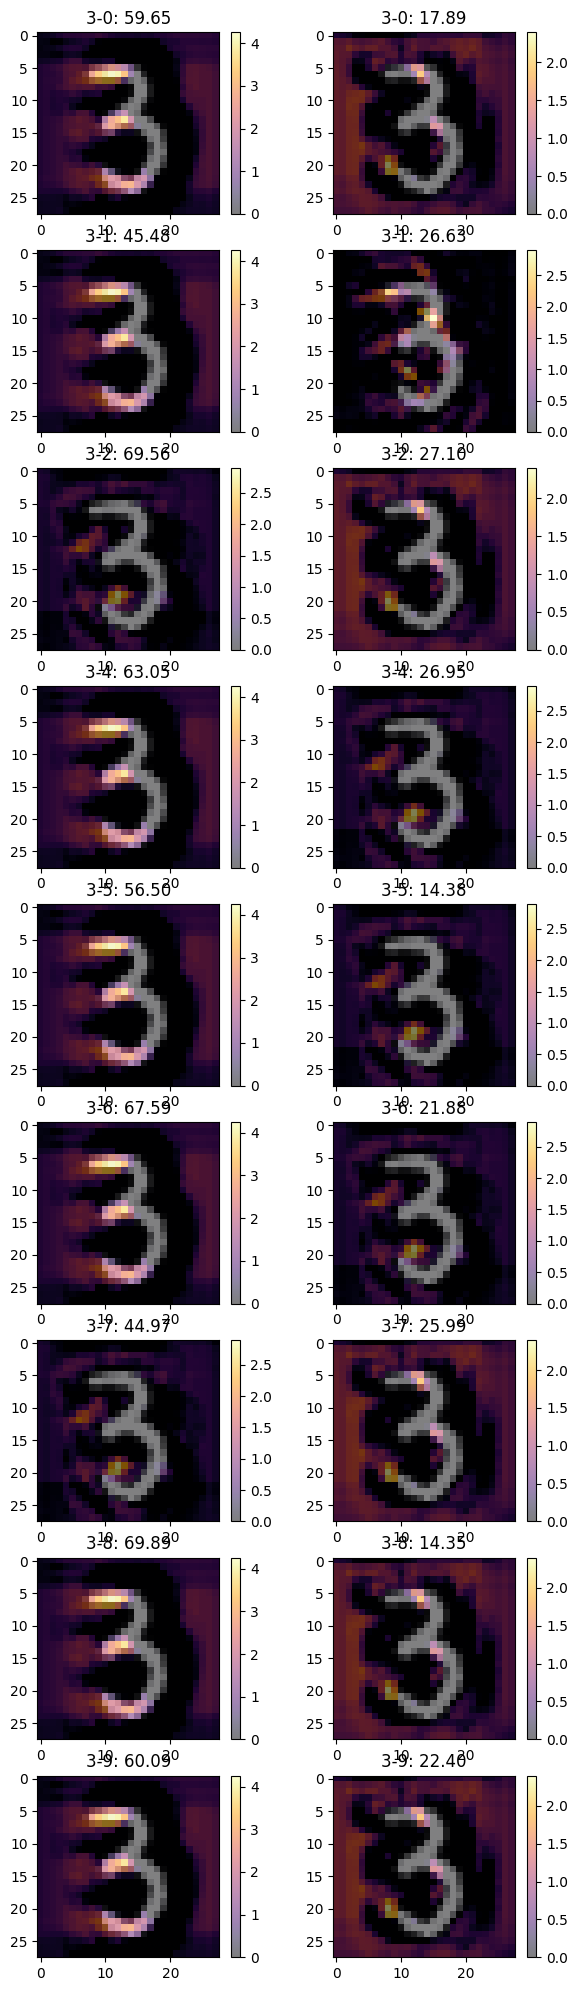

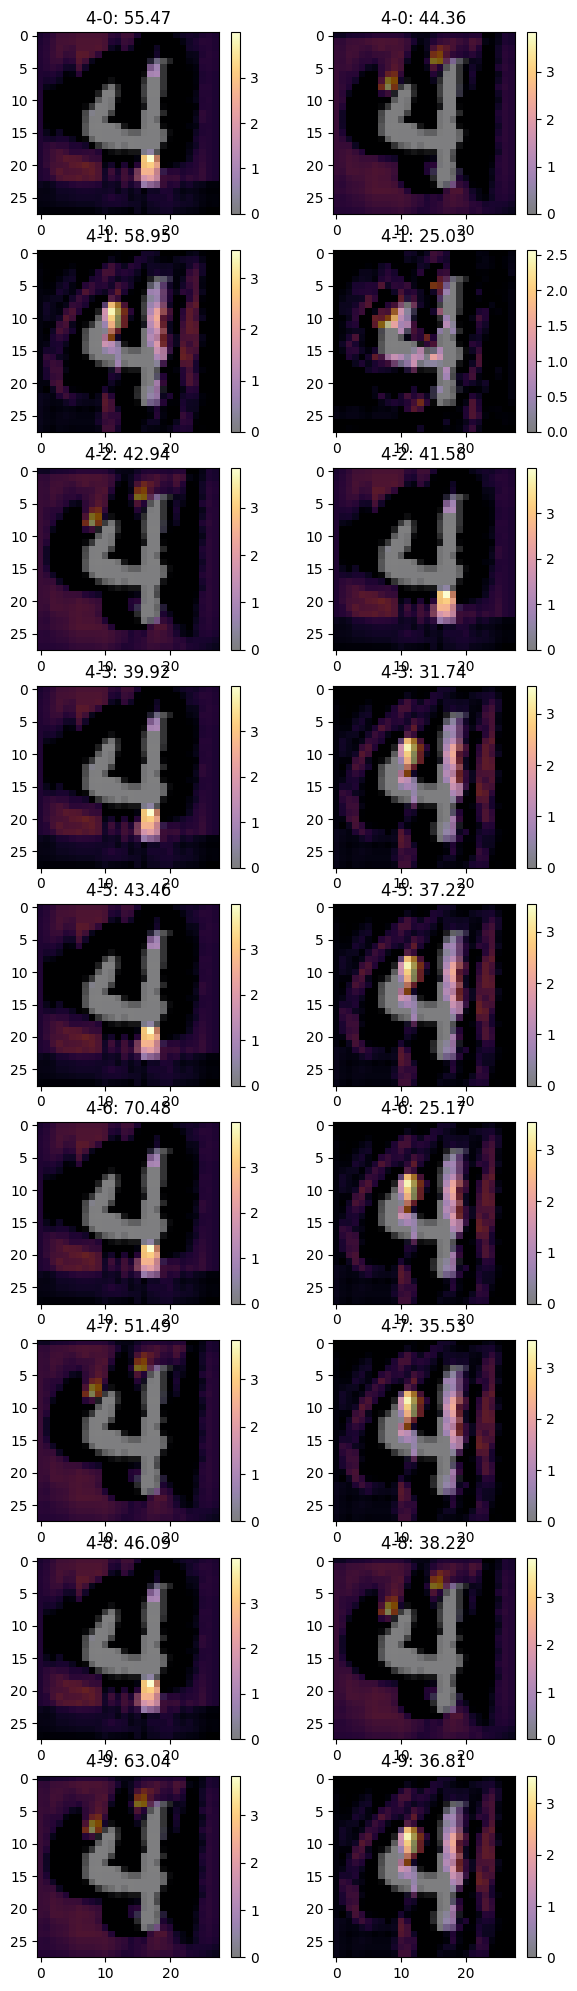

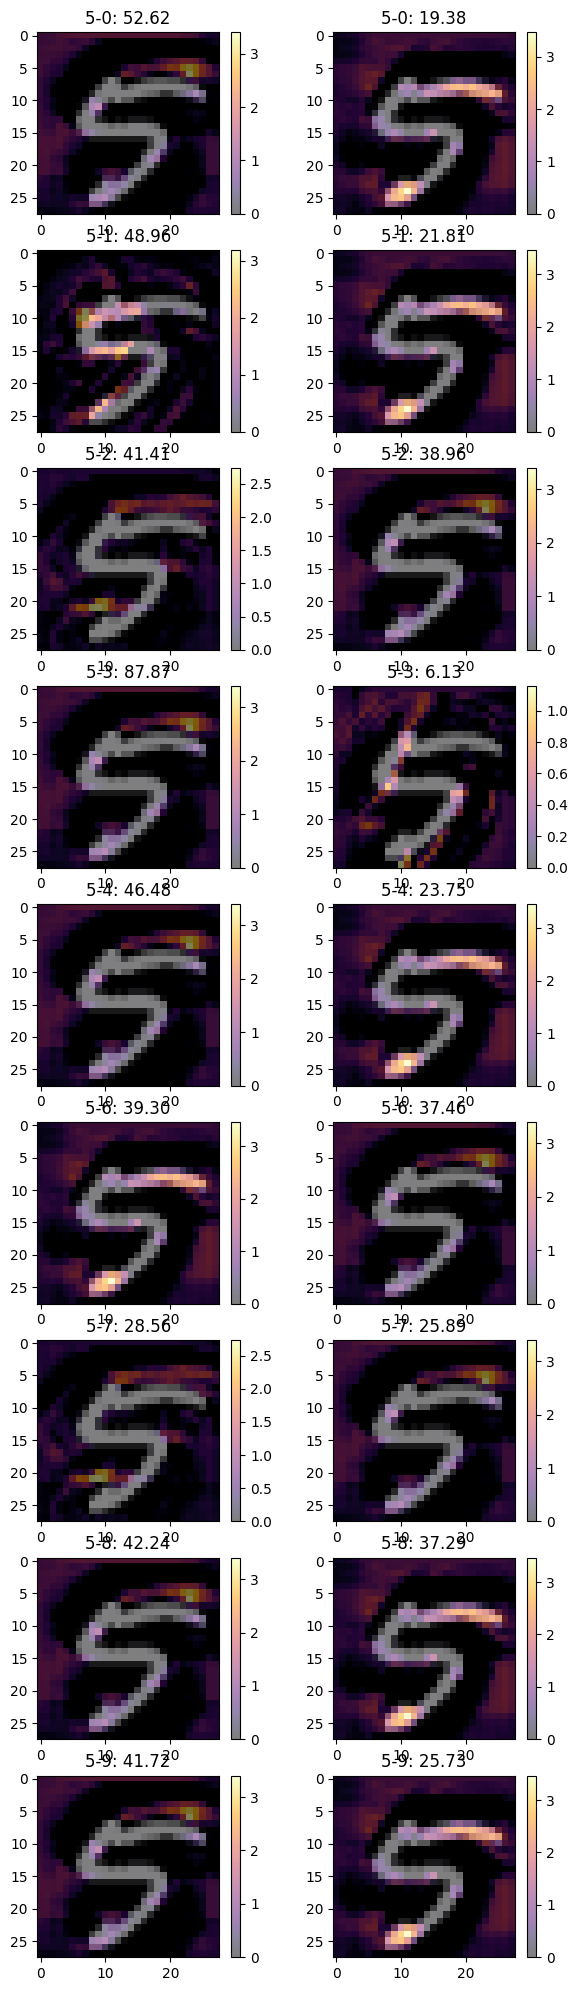

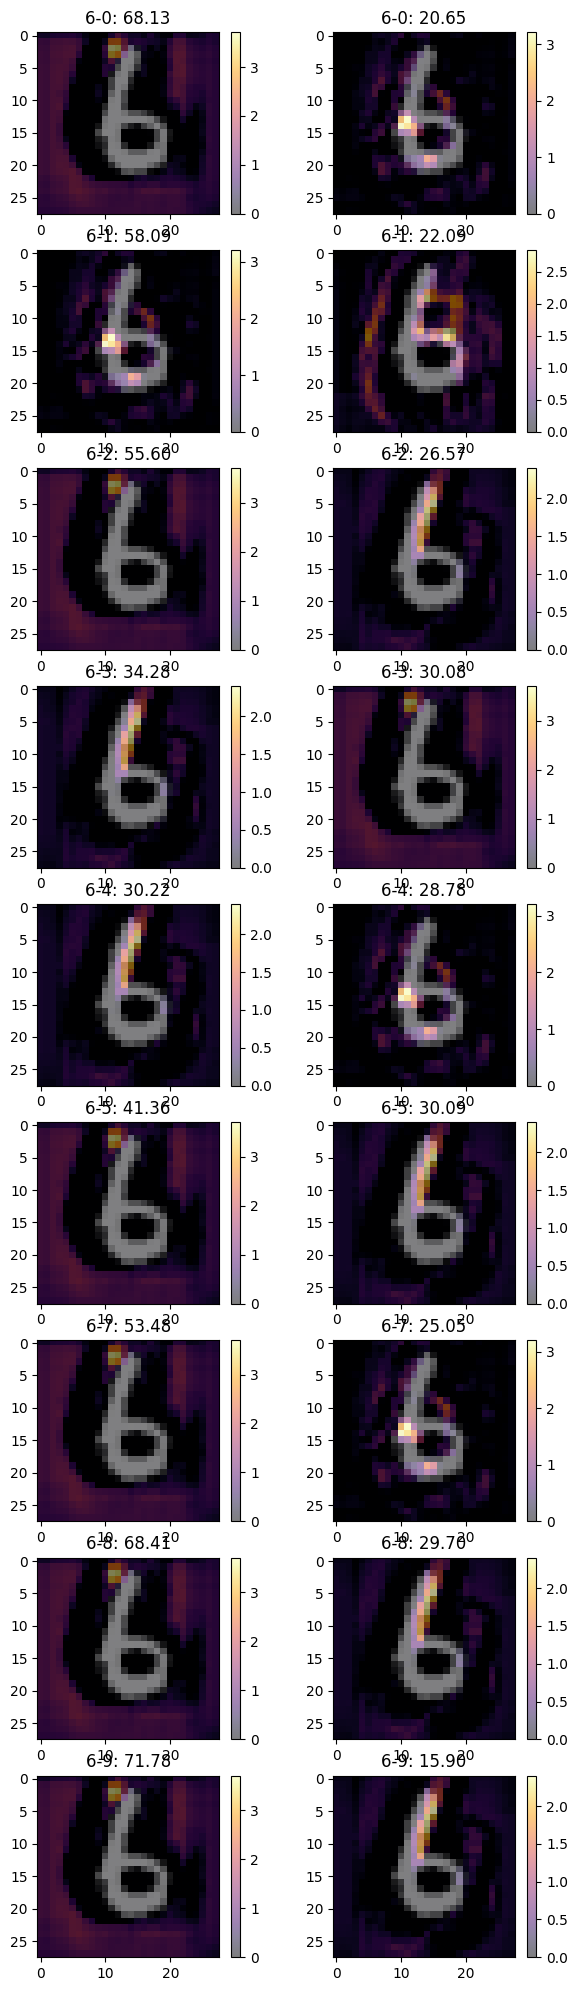

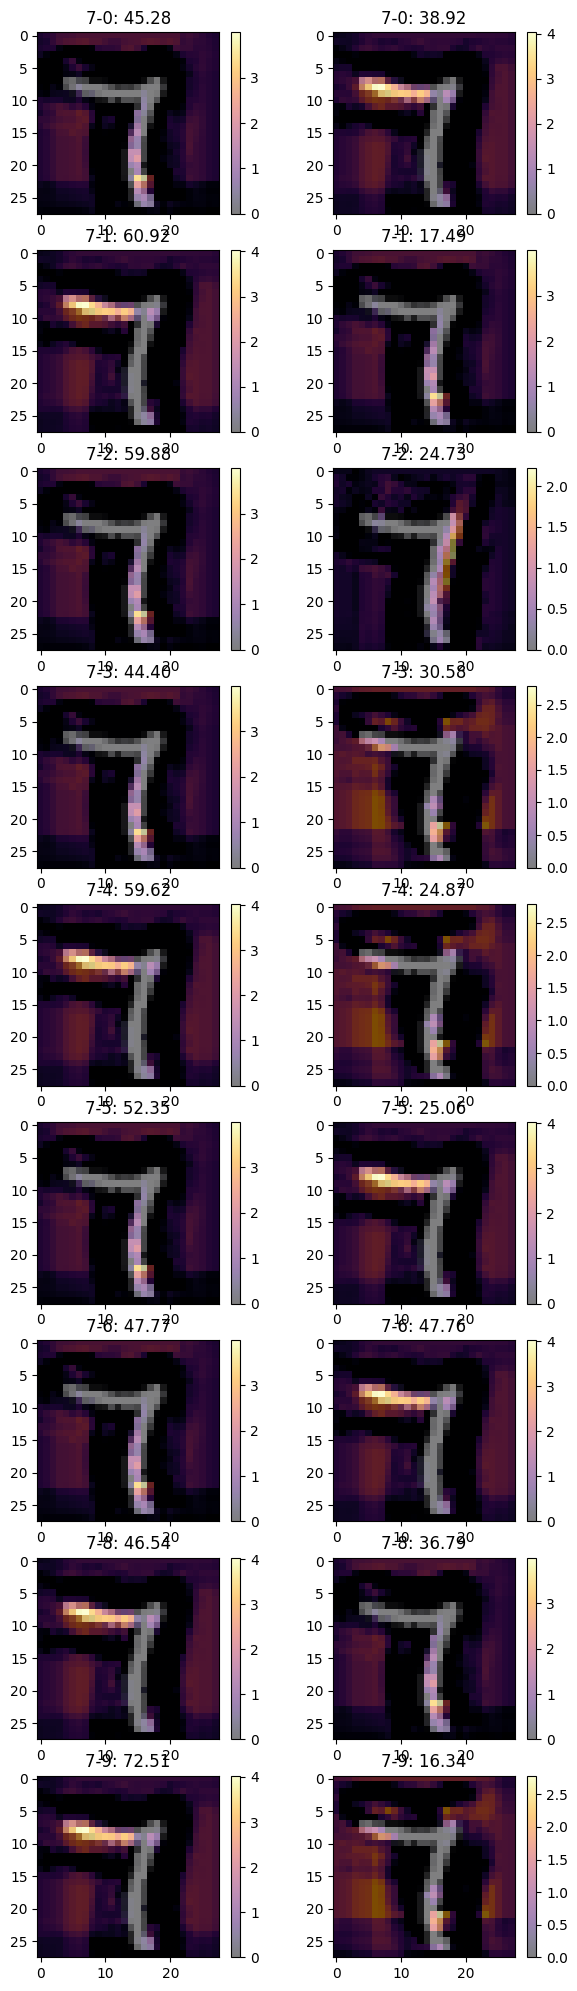

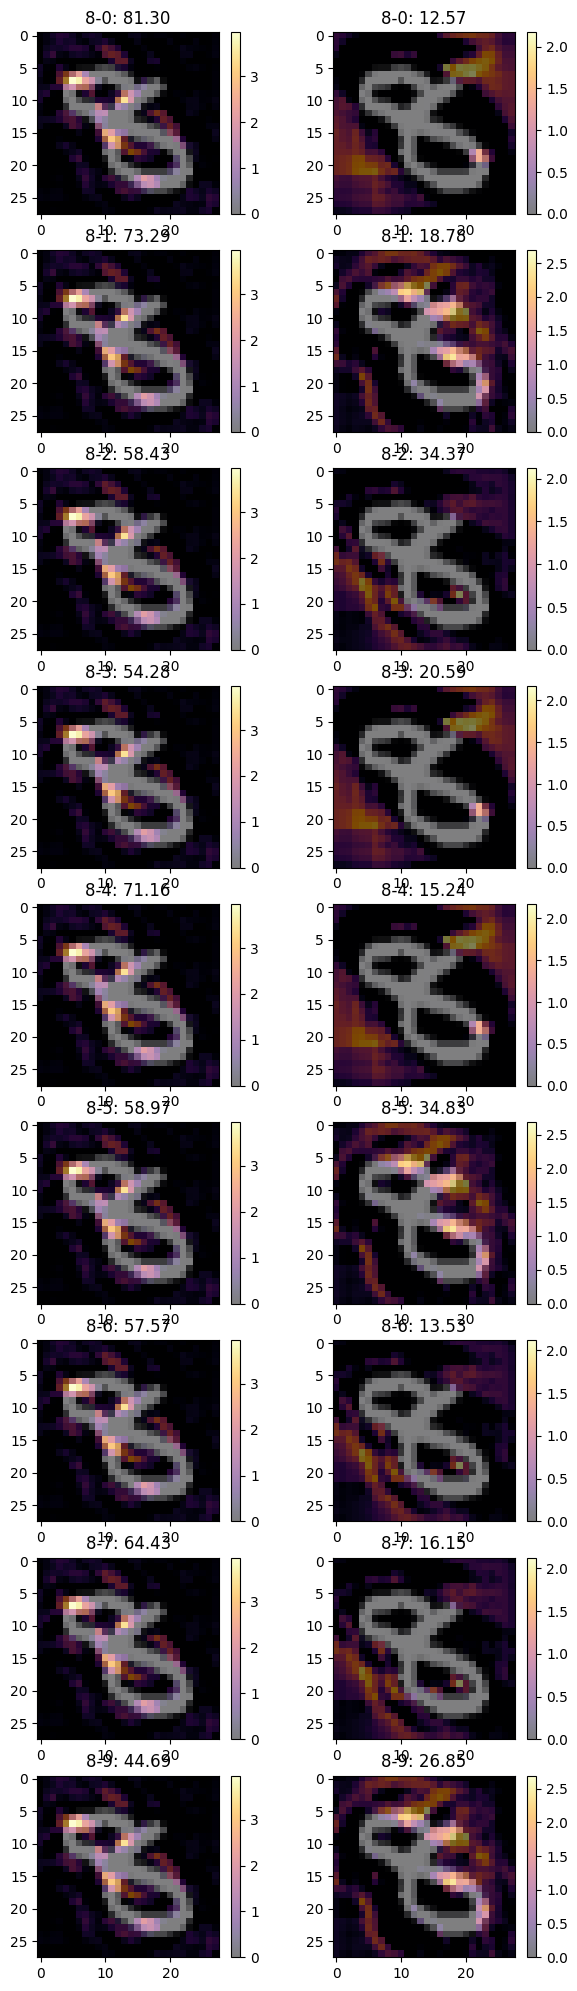

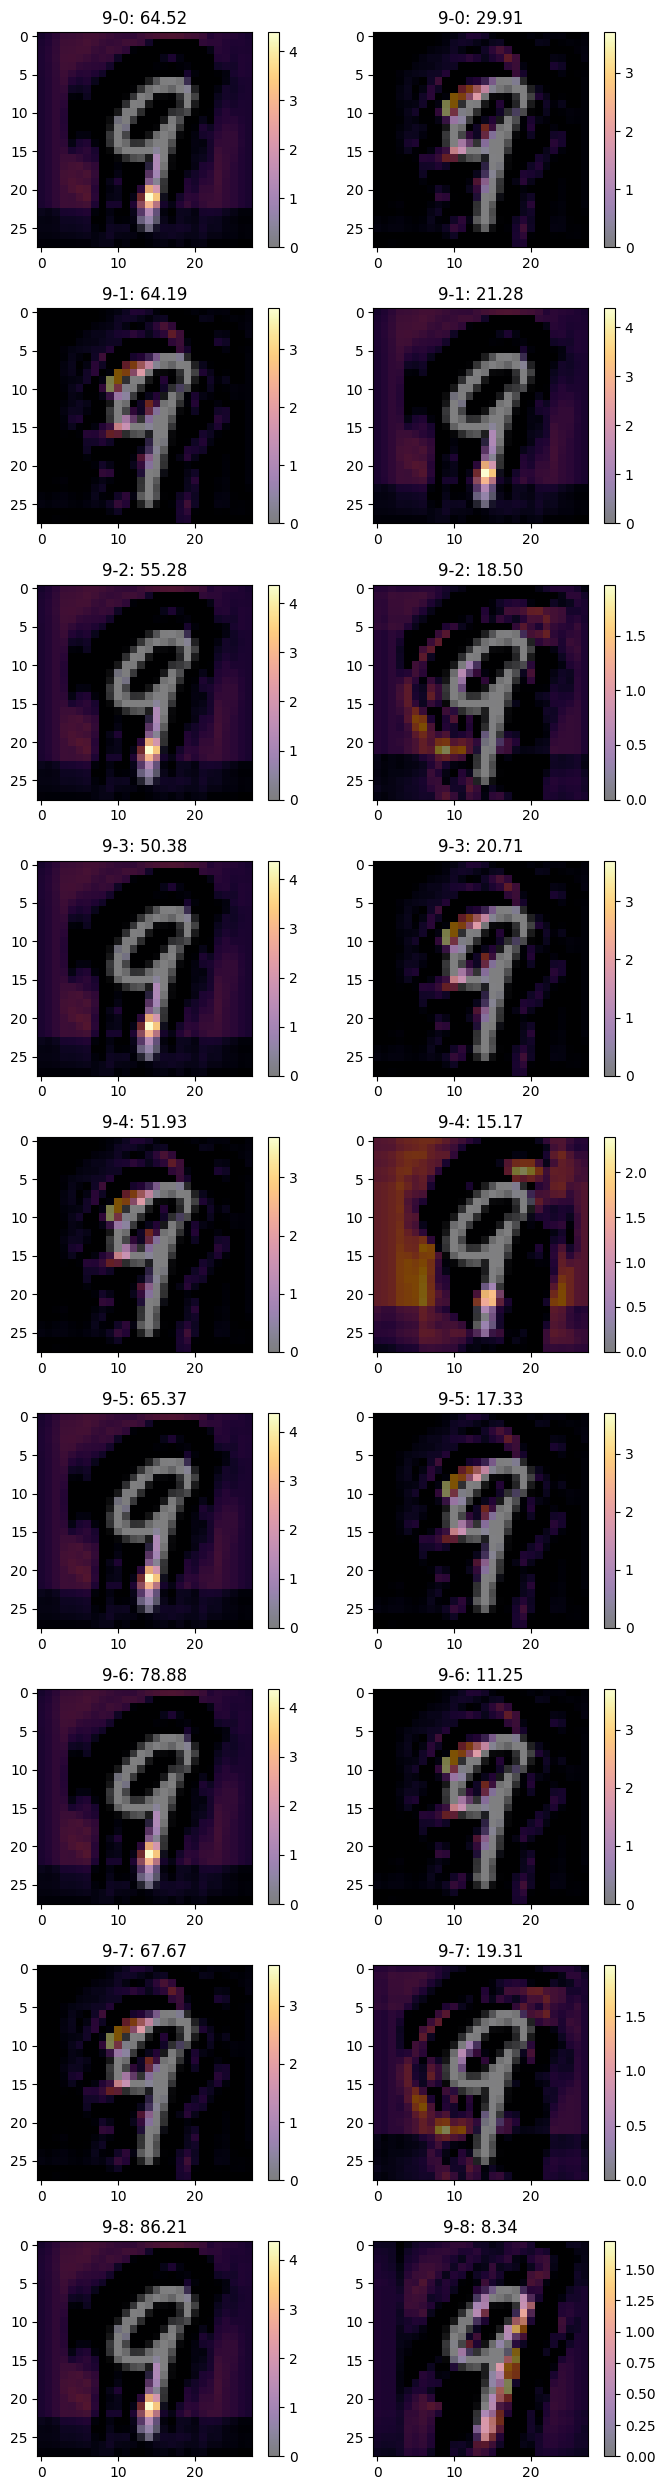

In [28]:
maps = interpret_pairwise(samples, model, n=2)
plot_pairwise_maps(samples, maps)